In [ ]:
# create a word cloud from the review comments
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from matplotlib.font_manager import FontProperties
import matplotlib.ticker as mtick
import string
import re
import os
import pandas as pd
import numpy as np
font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
import spacy


research_categories = {
    "Arts & Humanities": ["Architecture", "Art", "Arts & Humanities Other Topics", "Asian Studies", "Classics", "Dance",
                          "Film, Radio & Television", "History", "History & Philosophy of Science", "Literature", "Music",
                          "Philosophy", "Religion", "Theater"],
    "Life Sciences & Biomedicine": ["Agriculture", "Allergy", "Anatomy & Morphology", "Anesthesiology", "Anthropology",
                                    "Audiology & Speech-Language Pathology", "Behavioral Sciences", "Biochemistry & Molecular Biology",
                                    "Biodiversity & Conservation", "Biophysics", "Biotechnology & Applied Microbiology", "Cardiovascular System & Cardiology",
                                    "Cell Biology", "Critical Care Medicine", "Dentistry, Oral Surgery & Medicine", "Dermatology", "Developmental Biology",
                                    "Emergency Medicine", "Endocrinology & Metabolism", "Entomology", "Environmental Sciences & Ecology", "Evolutionary Biology",
                                    "Fisheries", "Food Science & Technology", "Forestry", "Gastroenterology & Hepatology", "General & Internal Medicine",
                                    "Genetics & Heredity", "Geriatrics & Gerontology", "Health Care Sciences & Services", "Hematology", "Immunology",
                                    "Infectious Diseases", "Integrative & Complementary Medicine", "Legal Medicine", "Life Sciences Biomedicine Other Topics",
                                    "Marine & Freshwater Biology", "Mathematical & Computational Biology", "Medical Ethics", "Medical Informatics", "Medical Laboratory Technology",
                                    "Microbiology", "Mycology", "Neurosciences & Neurology", "Nursing", "Nutrition & Dietetics", "Obstetrics & Gynecology",
                                    "Oncology", "Ophthalmology", "Orthopedics", "Otorhinolaryngology", "Paleontology", "Parasitology", "Pathology", "Pediatrics",
                                    "Pharmacology & Pharmacy", "Physiology", "Plant Sciences", "Psychiatry", "Public, Environmental & Occupational Health", "Radiology, Nuclear Medicine & Medical Imaging",
                                    "Rehabilitation", "Reproductive Biology", "Research & Experimental Medicine", "Respiratory System", "Rheumatology", "Sport Sciences",
                                    "Substance Abuse", "Surgery", "Toxicology", "Transplantation", "Tropical Medicine", "Urology & Nephrology", "Veterinary Sciences",
                                    "Virology", "Zoology"],
    "Physical Sciences": ["Astronomy & Astrophysics", "Chemistry", "Crystallography", "Electrochemistry", "Geochemistry & Geophysics",
                          "Geology", "Mathematics", "Meteorology & Atmospheric Sciences", "Mineralogy", "Mining & Mineral Processing",
                          "Oceanography", "Optics", "Physical Geography", "Physics", "Polymer Science", "Thermodynamics", "Water Resources"],
    "Social Sciences": ["Archaeology", "Area Studies", "Biomedical Social Sciences", "Business & Economics", "Communication",
                        "Criminology & Penology", "Cultural Studies", "Demography", "Development Studies", "Education & Educational Research",
                        "Ethnic Studies", "Family Studies", "Geography", "Government & Law", "International Relations", "Linguistics",
                        "Mathematical Methods In Social Sciences", "Psychology", "Public Administration", "Social Issues",
                        "Social Sciences Other Topics", "Social Work", "Sociology", "Urban Studies", "Women's Studies"],
    "Technology": ["Acoustics", "Automation & Control Systems", "Computer Science", "Construction & Building Technology", "Energy & Fuels",
                   "Engineering", "Imaging Science & Photographic Technology", "Information Science & Library Science", "Instruments & Instrumentation",
                   "Materials Science", "Mechanics", "Metallurgy & Metallurgical Engineering", "Microscopy", "Nuclear Science & Technology",
                   "Operations Research & Management Science", "Remote Sensing", "Robotics", "Science & Technology Other Topics",
                   "Spectroscopy", "Telecommunications", "Transportation"]
}

In [26]:
import pandas as pd
import os

# Load all data
exportfolder = "/group/geog_pyloo/XY/01_gender/_data/_clean"

files = [
    'cleandata_people.csv',
    'cleandata_living.csv',
    'cleandata_mobility.csv',
    'cleandata_economy.csv',
    'cleandata_governance.csv',
    'cleandata_city.csv',
    'cleandata_environment.csv',
    'cleandata_ai.csv'
]

# Read and concatenate all data
DF = []
for f in files:
    temp = pd.read_csv(os.path.join(exportfolder, f))
    temp['keyword'] = f.split('_')[1].split('.')[0]
    DF.append(temp)
DF = pd.concat(DF).reset_index(drop=True)

# Remove duplicate rows based on 'Article Title'
DF = DF.drop_duplicates(subset=['Article Title'], keep='first').reset_index(drop=True)

# Save the combined data to a new CSV file
combined_file_path = os.path.join(exportfolder, 'cleandata_all.csv')
DF.to_csv(combined_file_path, index=False)

print(f"Combined data saved to {combined_file_path}")


Combined data saved to /group/geog_pyloo/XY/01_gender/_data/_clean/cleandata_all.csv


In [27]:
# load all data
exportfolder = "/group/geog_pyloo/XY/01_gender/_data/_clean"
exportfolder2 = "/group/geog_pyloo/XY/01_gender/_data/wordmerged"
if not os.path.exists(exportfolder2):
    os.makedirs(exportfolder2)
files = [ 
 'cleandata_people.csv',
 'cleandata_living.csv',
 'cleandata_mobility.csv',
 'cleandata_economy.csv',
 'cleandata_governance.csv',
 'cleandata_city.csv',
 'cleandata_environment.csv',
 'cleandata_ai.csv',
]
DF = []
for f in files:
    temp = pd.read_csv(os.path.join(exportfolder, f))
    temp['keyword'] = f.split('_')[1].split('.')[0]
    temp = temp.drop_duplicates()
    DF.append(temp)
DF = pd.concat(DF).reset_index(drop = True)
# DF['keyword'] = np.where(DF['keyword'].isin(['living','people']), 'living&people', DF['keyword'])

/tmp/ipykernel_3574900/3751006327.py:19: DtypeWarning: Columns (15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(os.path.join(exportfolder, f))


# Clean the abstract

In [ ]:
# !pip install typing_extensions
import pandas as pd
import numpy as np
import spacy
import re
import string
import nltk
stopwords=[ ]
#extract only reviews
def get_one_class(DF, col, value):

    temp = DF[DF[col].isin(value)].reset_index(drop=True)
    comments = temp[~temp['Abstract'].isna()]['Abstract'].values
    comments = comments.astype('str')
    
    def _removeNonAscii(s): 
        return "".join(i for i in s if ord(i) < 128)
    
    comments = pd.Series(comments).apply(_removeNonAscii)
    print(comments.shape[0])
    
    STOPWORDS_DICT = {lang: set(stopwords.words(lang)) for lang in stopwords.fileids()}
    
    def get_language(text):
        words = set(nltk.wordpunct_tokenize(text.lower()))
        lang = max(((lang, len(words & stopwords)) for lang, stopwords in STOPWORDS_DICT.items()), key=lambda x: x[1])[0]
        if lang == 'english':
            return True
        else:
            return False
    
    return comments

    
def get_tokens(eng_comments):
    nlp = spacy.load("en_core_web_sm")

    def clean_comments(text):
        #remove punctuations
        regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
        nopunct = regex.sub(" ", str(text))
        #use spacy to lemmatize comments
        doc = nlp(nopunct, disable=['parser','ner'])
        lemma = [token.lemma_ for token in doc]
        return lemma

    lemmatized = eng_comments.map(clean_comments)

    lemmatized = lemmatized.map(lambda x: [word.lower() for word in x])

    unlist_comments = [item for items in lemmatized for item in items]
    return lemmatized, unlist_comments


In [29]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

# Initialize stopwords
en_stopwords = set(stopwords.words('english'))

# Function to filter for ADJ/NN bigrams
def rightTypes(ngram, en_stopwords=en_stopwords):
    if '-pron-' in ngram or '' in ngram or ' ' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in en_stopwords:
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False

def get_word_rank(DF, 
                  keyword=['environment'], 
                  gender="Male only",
                  en_stopwords=en_stopwords):
    comments = get_one_class(DF[DF['gender_label_2'] == gender], 
                             'keyword', 
                             keyword)
    _, unlist_comments = get_tokens(comments)
    
    bigrams = BigramAssocMeasures()
    bigramFinder = BigramCollocationFinder.from_words(unlist_comments)

    # Bigrams
    bigram_freq = bigramFinder.ngram_fd.items()
    bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram', 'freq']).sort_values(by='freq', ascending=False)
    
    filtered_bi = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x))]
    
    # Filter for only those with more than 20 occurrences
    bigramFinder.apply_freq_filter(20)
    bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), 
                                  columns=['bigram', 'PMI']).sort_values(by='PMI', ascending=False)
    
    # Merge the bigramPMITable and bigramFreqTable
    mergedbig = filtered_bi.merge(bigramPMITable, on='bigram', how='inner')
    mergedbig['freqxPMI'] = mergedbig['freq'] * mergedbig['PMI']
    mergedbig = mergedbig.sort_values(by='freqxPMI', ascending=False)
    
    return mergedbig

# Function to combine male and female results
def mergetwo(mergedbig_male, mergedbig_female, mergecol='bigram'):
    gendercomp = mergedbig_male.merge(
        mergedbig_female,
        on=mergecol,
        how='outer',
        suffixes=('_male', '_female')
    ).reset_index(drop=True)
    
    gendercomp['text'] = gendercomp[mergecol].map(lambda x: ' '.join(x))
    gendercomp['freqxPMI_male'] = gendercomp['freqxPMI_male'].fillna(0)
    gendercomp['freqxPMI_female'] = gendercomp['freqxPMI_female'].fillna(0)
    gendercomp['freqxPMI_male_rank'] = gendercomp['freqxPMI_male'].rank(ascending=True, method='dense')
    gendercomp['freqxPMI_female_rank'] = gendercomp['freqxPMI_female'].rank(ascending=True, method='dense')
    gendercomp['rank_female_male'] = gendercomp.apply(lambda row: row['freqxPMI_female_rank'] - row['freqxPMI_male_rank'], axis=1)
    gendercomp['abs_rank_female_male'] = gendercomp.apply(lambda row: abs(row['freqxPMI_female_rank'] - row['freqxPMI_male_rank']), axis=1)
    gendercomp['total_rank'] = gendercomp.apply(lambda row: row['freqxPMI_female_rank'] + row['freqxPMI_male_rank'], axis=1)
    
    return gendercomp


In [30]:
import gc
gc.collect()
def mergetwo(mergedbig_male, mergedbig_female, mergecol = 'bigram'):
    gendercomp = mergedbig_male.merge(
    mergedbig_female,
    on = mergecol,
    how = 'outer',
    suffixes = ('_male','_female')
).reset_index(drop = True)
    # gendercomp = gendercomp[(gendercomp['freqxPMI_female']>0)&(gendercomp['freqxPMI_male']>0)].reset_index(drop = True)
    gendercomp['text'] = gendercomp[mergecol].map(lambda x: ' '.join(x))
    gendercomp['freqxPMI_male'] = gendercomp['freqxPMI_male'].fillna(0)
    gendercomp['freqxPMI_female'] = gendercomp['freqxPMI_female'].fillna(0)
    gendercomp['freqxPMI_male_rank'] = gendercomp['freqxPMI_male'].rank(ascending = True, method = 'dense')
    gendercomp['freqxPMI_female_rank'] = gendercomp['freqxPMI_female'].rank(ascending = True, method = 'dense')
    gendercomp['rank_female_male'] = gendercomp.apply(lambda row:
    row['freqxPMI_female_rank'] - row['freqxPMI_male_rank'], axis = 1)
    gendercomp['abs_rank_female_male'] = gendercomp.apply(lambda row:
        abs(row['freqxPMI_female_rank'] - row['freqxPMI_male_rank']), axis = 1)
    gendercomp['total_rank'] = gendercomp.apply(lambda row:
        row['freqxPMI_female_rank'] + row['freqxPMI_male_rank'], axis = 1)
    return gendercomp
    

In [31]:
gc.collect()

0

In [32]:

def get_result(DF, keyword):
    mergedbig_male, mergedtri_male = get_word_rank(DF,
                                        keyword = keyword, 
                    gender = "Male only",
                    en_stopwords = en_stopwords
                                        )
    mergedbig_female, mergedtri_female = get_word_rank(DF,
                                        keyword = keyword, 
                    gender = "withFemale",
                    en_stopwords = en_stopwords
                                        )
    gendercomp = mergetwo(mergedbig_male, mergedbig_female, mergecol = 'bigram')
    keyword_str = "_".join(keyword)
    gendercomp.to_csv(os.path.join(exportfolder2, 'gendercomp_{}_big.csv'.format(keyword_str)), index = False)
    
    gendercomp_tri = mergetwo(mergedtri_male, mergedtri_female, mergecol = 'trigram')
    gendercomp_tri.to_csv(os.path.join(exportfolder2, 'gendercomp_{}_tri.csv'.format(keyword_str)), index = False)

In [33]:
varls = DF.keyword.unique()
varls

array(['all'], dtype=object)

In [34]:
DF_unique = DF.drop_duplicates("Authors")

In [ ]:
for keyword in [ 
        'people', 'living', 'mobility', 'economy', 'governance', 'city','environment', 'ai'
                ]:
    print(keyword)
    get_result(DF, [keyword])

all

In [ ]:

# Load stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
en_stopwords = set(stopwords.words('english'))



def get_one_class(DF, col, value):
    # Filter for specific class
    temp = DF[DF[col].isin(value)].reset_index(drop=True)
    comments = temp[~temp['Abstract'].isna()]['Abstract'].values
    comments = comments.astype('str')
    
    # Remove non-ASCII characters
    def _removeNonAscii(s): 
        return "".join(i for i in s if ord(i) < 128)
    
    comments = pd.Series(comments).apply(_removeNonAscii)
    print(comments.shape[0])
    
    # Get stopwords for all languages
    STOPWORDS_DICT = {lang: set(stopwords.words(lang)) for lang in stopwords.fileids()}
    
    # Detect language
    def get_language(text):
        words = set(nltk.wordpunct_tokenize(text.lower()))
        lang = max(((lang, len(words & stopwords)) for lang, stopwords in STOPWORDS_DICT.items()), key=lambda x: x[1])[0]
        if lang == 'english':
            return True
        else:
            return False
    
    return comments

def get_tokens(eng_comments):
    # Load spacy
    nlp = spacy.load("en_core_web_sm")

    # Function to clean and lemmatize comments
    def clean_comments(text):
        # Remove punctuations
        regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
        nopunct = regex.sub(" ", str(text))
        # Use spacy to lemmatize comments
        doc = nlp(nopunct, disable=['parser','ner'])
        lemma = [token.lemma_ for token in doc]
        return lemma

    # Apply function to clean and lemmatize comments
    lemmatized = eng_comments.map(clean_comments)

    # Make sure to lowercase everything
    lemmatized = lemmatized.map(lambda x: [word.lower() for word in x])

    # Turn all comments' tokens into one single list
    unlist_comments = [item for items in lemmatized for item in items]
    return lemmatized, unlist_comments

def get_word_rank(DF, keyword=['environment'], gender="Male only", en_stopwords=en_stopwords):
    comments = get_one_class(DF[DF['gender_label_2'] == gender], 'keyword', keyword)
    _, unlist_comments = get_tokens(comments)
    
    bigrams = BigramAssocMeasures()
    bigramFinder = BigramCollocationFinder.from_words(unlist_comments)

    # Apply frequency filter
    bigramFinder.apply_freq_filter(20)

    # Bigrams
    bigram_freq = bigramFinder.ngram_fd.items()
    bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram', 'freq']).sort_values(by='freq', ascending=False)
    
    filtered_bi = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x))]
    
    bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), columns=['bigram', 'PMI']).sort_values(by='PMI', ascending=False)
    
    # Merge the bigramPMITable and bigramFreqTable
    mergedbig = filtered_bi.merge(bigramPMITable, on='bigram', how='inner')
    mergedbig['freqxPMI'] = mergedbig['freq'] * mergedbig['PMI']
    mergedbig = mergedbig.sort_values(by='freqxPMI', ascending=False)
    
    return mergedbig

# Function to combine male and female results
def mergetwo(mergedbig_male, mergedbig_female, mergecol='bigram'):
    gendercomp = mergedbig_male.merge(
        mergedbig_female,
        on=mergecol,
        how='outer',
        suffixes=('_male', '_female')
    ).reset_index(drop=True)
    
    gendercomp['text'] = gendercomp[mergecol].map(lambda x: ' '.join(x))
    gendercomp['freqxPMI_male'] = gendercomp['freqxPMI_male'].fillna(0)
    gendercomp['freqxPMI_female'] = gendercomp['freqxPMI_female'].fillna(0)
    gendercomp['freqxPMI_male_rank'] = gendercomp['freqxPMI_male'].rank(ascending=True, method='dense')
    gendercomp['freqxPMI_female_rank'] = gendercomp['freqxPMI_female'].rank(ascending=True, method='dense')
    gendercomp['rank_female_male'] = gendercomp.apply(lambda row: row['freqxPMI_female_rank'] - row['freqxPMI_male_rank'], axis=1)
    gendercomp['abs_rank_female_male'] = gendercomp.apply(lambda row: abs(row['freqxPMI_female_rank'] - row['freqxPMI_male_rank']), axis=1)
    gendercomp['total_rank'] = gendercomp.apply(lambda row: row['freqxPMI_female_rank'] + row['freqxPMI_male_rank'], axis=1)
    
    return gendercomp

def get_result(DF, keyword):
    mergedbig_male = get_word_rank(DF, keyword=keyword, gender="Male only", en_stopwords=en_stopwords)
    mergedbig_female = get_word_rank(DF, keyword=keyword, gender="withFemale", en_stopwords=en_stopwords)
    gendercomp = mergetwo(mergedbig_male, mergedbig_female, mergecol='bigram')
    keyword_str = "_".join(keyword)
    gendercomp.to_csv(os.path.join(exportfolder2, 'gendercomp_{}_big.csv'.format(keyword_str)), index=False)

for keyword in ['all']:
    print(keyword)
    get_result(DF, [keyword])


生成40

In [6]:

# 反向查找快速分类
category_lookup = {}
for category, topics in research_categories.items():
    for topic in topics:
        category_lookup[topic] = category

# 功能：分类研究领域
def classify_research_areas(research_areas):
    categories = set()
    if isinstance(research_areas, str):  # 确保research_areas是字符串
        for area in research_areas.split(';'):
            area = area.strip()
            if area in category_lookup:
                categories.add(category_lookup[area])
    return categories

# 加载stopwords
en_stopwords = set(stopwords.words('english'))

# 功能：筛选ADJ/NN bigrams
def rightTypes(ngram, en_stopwords=en_stopwords):
    if '-pron-' in ngram or '' in ngram or ' ' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in en_stopwords:
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False

# 功能：筛选特定类
def get_one_class(DF, col, value):
    temp = DF[DF[col].isin(value)].reset_index(drop=True)
    comments = temp[~temp['Abstract'].isna()]['Abstract'].values
    comments = comments.astype('str')
    
    def _removeNonAscii(s):
        return "".join(i for i in s if ord(i) < 128)
    
    comments = pd.Series(comments).apply(_removeNonAscii)
    print(comments.shape[0])
    
    STOPWORDS_DICT = {lang: set(stopwords.words(lang)) for lang in stopwords.fileids()}
    
    def get_language(text):
        words = set(nltk.wordpunct_tokenize(text.lower()))
        lang = max(((lang, len(words & stopwords)) for lang, stopwords in STOPWORDS_DICT.items()), key=lambda x: x[1])[0]
        if lang == 'english':
            return True
        else:
            return False
    
    return comments

# 功能：获取token
def get_tokens(eng_comments):
    nlp = spacy.load("en_core_web_sm")

    def clean_comments(text):
        regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
        nopunct = regex.sub(" ", str(text))
        doc = nlp(nopunct, disable=['parser','ner'])
        lemma = [token.lemma_ for token in doc]
        return lemma

    lemmatized = eng_comments.map(clean_comments)
    lemmatized = lemmatized.map(lambda x: [word.lower() for word in x])
    unlist_comments = [item for items in lemmatized for item in items]
    return lemmatized, unlist_comments

# 功能：获取单个性别的word rank
def get_word_rank(DF, keyword=['environment'], gender="Male only", en_stopwords=en_stopwords):
    comments = get_one_class(DF[DF['gender_label_2'] == gender], 'keyword', keyword)
    _, unlist_comments = get_tokens(comments)
    
    bigrams = BigramAssocMeasures()
    bigramFinder = BigramCollocationFinder.from_words(unlist_comments)
    bigramFinder.apply_freq_filter(20)

    bigram_freq = bigramFinder.ngram_fd.items()
    bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram', 'freq']).sort_values(by='freq', ascending=False)
    
    filtered_bi = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x))]
    
    bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), columns=['bigram', 'PMI']).sort_values(by='PMI', ascending=False)
    
    mergedbig = filtered_bi.merge(bigramPMITable, on='bigram', how='inner')
    mergedbig['freqxPMI'] = mergedbig['freq'] * mergedbig['PMI']
    mergedbig = mergedbig.sort_values(by='freqxPMI', ascending=False)
    
    return mergedbig

# 功能：合并男性和女性结果
def mergetwo(mergedbig_male, mergedbig_female, mergecol='bigram'):
    gendercomp = mergedbig_male.merge(
        mergedbig_female,
        on=mergecol,
        how='outer',
        suffixes=('_male', '_female')
    ).reset_index(drop=True)
    
    gendercomp['text'] = gendercomp[mergecol].map(lambda x: ' '.join(x))
    gendercomp['freqxPMI_male'] = gendercomp['freqxPMI_male'].fillna(0)
    gendercomp['freqxPMI_female'] = gendercomp['freqxPMI_female'].fillna(0)
    gendercomp['freqxPMI_male_rank'] = gendercomp['freqxPMI_male'].rank(ascending=True, method='dense')
    gendercomp['freqxPMI_female_rank'] = gendercomp['freqxPMI_female'].rank(ascending=True, method='dense')
    gendercomp['rank_female_male'] = gendercomp.apply(lambda row: row['freqxPMI_female_rank'] - row['freqxPMI_male_rank'], axis=1)
    gendercomp['abs_rank_female_male'] = gendercomp.apply(lambda row: abs(row['freqxPMI_female_rank'] - row['freqxPMI_male_rank']), axis=1)
    gendercomp['total_rank'] = gendercomp.apply(lambda row: row['freqxPMI_female_rank'] + row['freqxPMI_male_rank'], axis=1)
    
    return gendercomp

# 功能：获取结果
def get_result(DF, keyword, file):
    mergedbig_male = get_word_rank(DF, keyword=keyword, gender="Male only", en_stopwords=en_stopwords)
    mergedbig_female = get_word_rank(DF, keyword=keyword, gender="withFemale", en_stopwords=en_stopwords)
    gendercomp = mergetwo(mergedbig_male, mergedbig_female, mergecol='bigram')
    keyword_str = "_".join(keyword)
    filename = os.path.basename(file).replace('cleandata_', '').replace('.csv', '')
    gendercomp.to_csv(os.path.join(exportfolder2, f'gendercomp_{filename}_{keyword_str}_big.csv'), index=False)


def revise_rank(gendercomp):
    gendercomp['freqxPMI_male_rank'] = gendercomp['freqxPMI_male'].rank(ascending=True, method='dense')
    gendercomp['freqxPMI_female_rank'] = gendercomp['freqxPMI_female'].rank(ascending=True, method='dense')
    gendercomp['freqxPMI_male_rank_score'] = (gendercomp['freqxPMI_male_rank'] - gendercomp['freqxPMI_male_rank'].min()) / (gendercomp['freqxPMI_male_rank'].max() - gendercomp['freqxPMI_male_rank'].min()) * 100
    gendercomp['freqxPMI_female_rank_score'] = (gendercomp['freqxPMI_female_rank'] - gendercomp['freqxPMI_female_rank'].min()) / (gendercomp['freqxPMI_female_rank'].max() - gendercomp['freqxPMI_female_rank'].min()) * 100
    gendercomp['rank_female_male_score'] = gendercomp.apply(lambda row: row['freqxPMI_female_rank_score'] - row['freqxPMI_male_rank_score'], axis=1)
    gendercomp['abs_rank_female_male_score'] = gendercomp.apply(lambda row: abs(row['freqxPMI_female_rank_score'] - row['freqxPMI_male_rank_score']), axis=1)
    gendercomp['total_rank_score'] = gendercomp.apply(lambda row: row['freqxPMI_female_rank_score'] + row['freqxPMI_male_rank_score'], axis=1)
    return gendercomp


In [ ]:
# 下载nltk所需资源
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

# 定义文件夹和变量
exportfolder = "/group/geog_pyloo/XY/01_gender/_data/_clean"
exportfolder2 = "/group/geog_pyloo/XY/01_gender/_data/40"

files = [
    'cleandata_people.csv',
    'cleandata_living.csv',
    'cleandata_mobility.csv',
    'cleandata_economy.csv',
    'cleandata_governance.csv',
    'cleandata_city.csv',
    'cleandata_environment.csv',
    'cleandata_ai.csv'
]

# 处理每个文件并分成五个类别
for file in files:
    filepath = os.path.join(exportfolder, file)
    if os.path.exists(filepath):
        DF = pd.read_csv(filepath)
        for category in research_categories.keys():
            category_df = DF[DF['Research Areas'].apply(lambda x: category in classify_research_areas(x))]
            if not category_df.empty:
                category_df['keyword'] = category
                get_result(category_df, [category], file)
    else:
        print(f"File not found: {filepath}")

生成40的R

In [21]:
import pandas as pd
import os

# Define folders and variables
exportfolder = "/group/geog_pyloo/XY/01_gender/_data/40"
varils = ['people', 'living', 'mobility', 'economy', 'governance', 'city', 'environment', 'ai']



# Load and process data
DFall = []
for keyword in varils:
    for category in ['Arts & Humanities', 'Life Sciences & Biomedicine', 'Physical Sciences', 'Social Sciences', 'Technology']:
        filepath = os.path.join(exportfolder, f'gendercomp_{keyword}_{category}_big.csv')
        if os.path.exists(filepath):
            df = pd.read_csv(filepath)
            df['keyword'] = keyword
            df['category'] = category
            df = revise_rank(df)
            DFall.append(df)
        else:
            print(f"File not found: {filepath}")

if DFall:
    DFall = pd.concat(DFall).reset_index(drop=True)
    print("Unique text: ", DFall['text'].nunique())
else:
    print("No data files found.")

# Save the data to a CSV file for use in R
DFall.to_csv(os.path.join(exportfolder, 'combined_data_for_R.csv'), index=False)


算14-23

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import spacy
import re
import string

# 定义文件路径
data_path = "/group/geog_pyloo/XY/01_gender/_data/_clean/cleandata_all.csv"

# 加载数据
df = pd.read_csv(data_path)

# 反向查找快速分类
category_lookup = {}
for category, topics in research_categories.items():
    for topic in topics:
        category_lookup[topic] = category

# 功能：分类研究领域
def classify_research_areas(research_areas):
    categories = set()
    if isinstance(research_areas, str):  # 确保research_areas是字符串
        for area in research_areas.split(';'):
            area = area.strip()
            if area in category_lookup:
                categories.add(category_lookup[area])
    return categories

# 为每个研究领域添加分类列
df['Category'] = df['Research Areas'].apply(lambda x: list(classify_research_areas(x))[0] if classify_research_areas(x) else 'Unknown')

# 筛选出2014-2023年的数据
df = df[(df['Publication Year'] >= 2014) & (df['Publication Year'] <= 2023)]


/tmp/ipykernel_1967998/324076163.py:14: DtypeWarning: Columns (15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


In [34]:
# 加载stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
en_stopwords = set(stopwords.words('english'))

# 使用提供的函数
annual_results = []

def get_result(DF, year, category):
    comments_male = get_one_class(DF[DF['gender_label_2'] == "Male only"], 'Category', [category])
    comments_female = get_one_class(DF[DF['gender_label_2'] == "withFemale"], 'Category', [category])
    
    tokens_male, unlist_comments_male = get_tokens(comments_male)
    tokens_female, unlist_comments_female = get_tokens(comments_female)
    
    bigrams_male = BigramCollocationFinder.from_words(unlist_comments_male)
    bigrams_female = BigramCollocationFinder.from_words(unlist_comments_female)
    
    bigrams_male.apply_freq_filter(5)
    bigrams_female.apply_freq_filter(5)
    
    bigram_freq_male = bigrams_male.ngram_fd.items()
    bigram_freq_female = bigrams_female.ngram_fd.items()
    
    bigramFreqTable_male = pd.DataFrame(list(bigram_freq_male), columns=['bigram', 'freq']).sort_values(by='freq', ascending=False)
    bigramFreqTable_female = pd.DataFrame(list(bigram_freq_female), columns=['bigram', 'freq']).sort_values(by='freq', ascending=False)
    
    filtered_bi_male = bigramFreqTable_male[bigramFreqTable_male.bigram.map(lambda x: rightTypes(x))]
    filtered_bi_female = bigramFreqTable_female[bigramFreqTable_female.bigram.map(lambda x: rightTypes(x))]
    
    bigramPMITable_male = pd.DataFrame(list(bigrams_male.score_ngrams(BigramAssocMeasures().pmi)), columns=['bigram', 'PMI']).sort_values(by='PMI', ascending=False)
    bigramPMITable_female = pd.DataFrame(list(bigrams_female.score_ngrams(BigramAssocMeasures().pmi)), columns=['bigram', 'PMI']).sort_values(by='PMI', ascending=False)
    
    mergedbig_male = filtered_bi_male.merge(bigramPMITable_male, on='bigram', how='inner')
    mergedbig_male['freqxPMI'] = mergedbig_male['freq'] * mergedbig_male['PMI']
    mergedbig_male = mergedbig_male.sort_values(by='freqxPMI', ascending=False)
    
    mergedbig_female = filtered_bi_female.merge(bigramPMITable_female, on='bigram', how='inner')
    mergedbig_female['freqxPMI'] = mergedbig_female['freq'] * mergedbig_female['PMI']
    mergedbig_female = mergedbig_female.sort_values(by='freqxPMI', ascending=False)
    
    gendercomp = mergetwo(mergedbig_male, mergedbig_female, mergecol='bigram')
    gendercomp['Year'] = year
    gendercomp['Category'] = category
    
    return revise_rank(gendercomp)

for year in range(2014, 2023 + 1):
    for category in research_categories.keys():
        df_year = df[(df['Publication Year'] == year) & (df['Category'] == category)]
        if not df_year.empty:
            result = get_result(df_year, year, category)
            annual_results.append(result)

# 转换为DataFrame
annual_results_df = pd.concat(annual_results).reset_index(drop=True)

# 计算每年每个类别的平均频率得分
annual_trends = annual_results_df.groupby(['Year', 'Category']).agg(
    avg_male_freqxPMI=('freqxPMI_male', 'mean'),
    avg_female_freqxPMI=('freqxPMI_female', 'mean')
).reset_index()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/u3575947/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/u3575947/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/u3575947/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


31
15
272
197
107
41
260
154
1960
548
51
32
379
231
100
40
268
214
2387
723
76
46
508
306
137
57
377
237
3178
1115
87
44
631
410
221
90
465
333
4194
1516
115
75
1044
653
273
99
688
483
5584
2044
174
88
1777
1075
314
143
1087
683
6970
2740
180
97
2787
1823
455
212
1264
847
7755
3169
176
121
4179
2950
601
301
1550
1187
9340
4150
234
146
5336
4166
759
425
1911
1656
10896
5372
276
155
6154
4781
780
427
2349
1748
10550
5419


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x800 with 0 Axes>

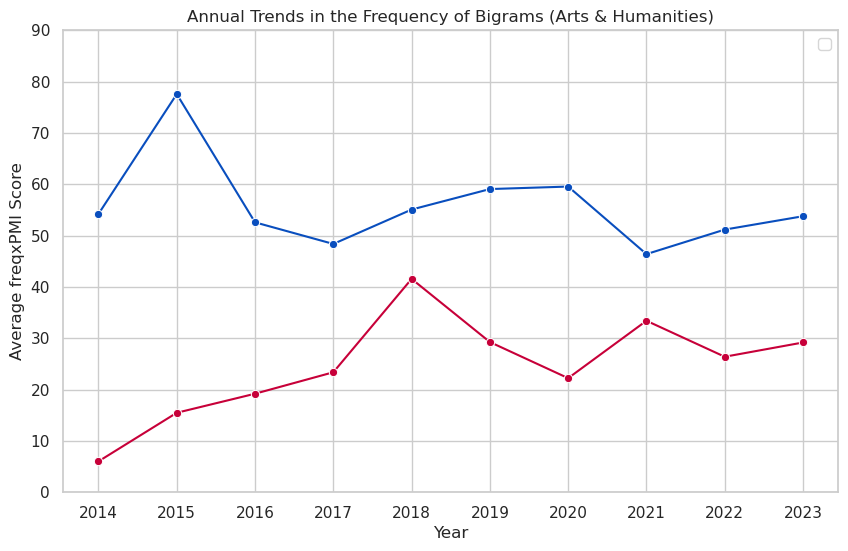

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


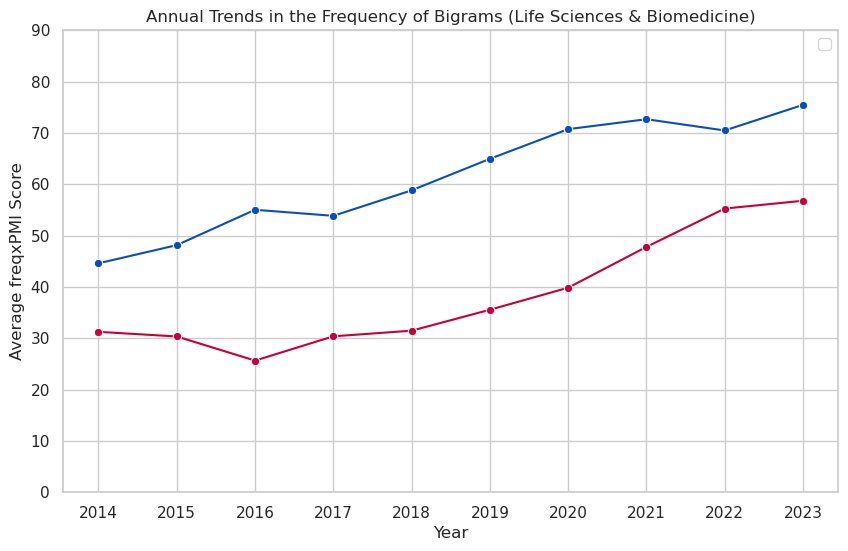

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


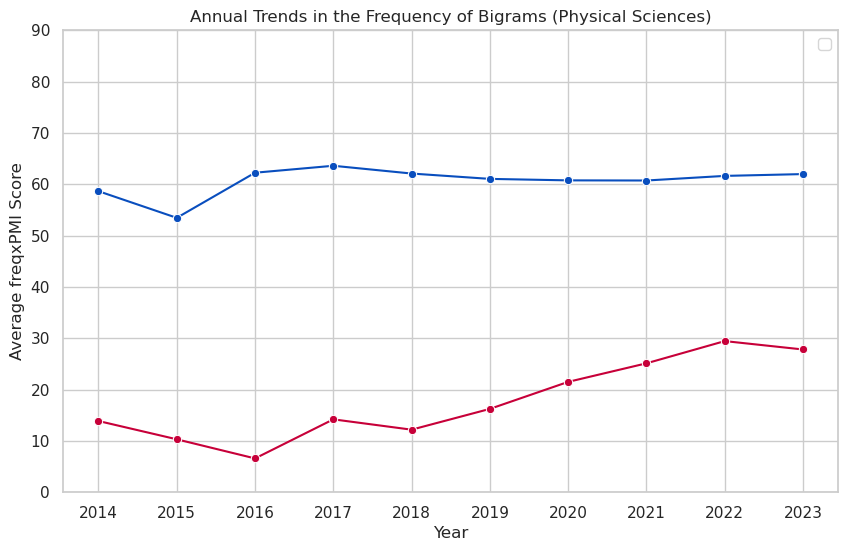

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


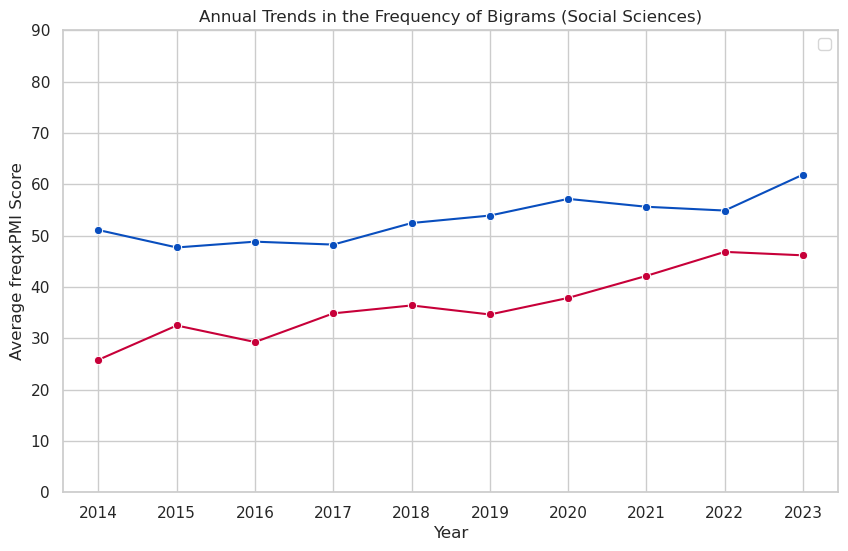

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


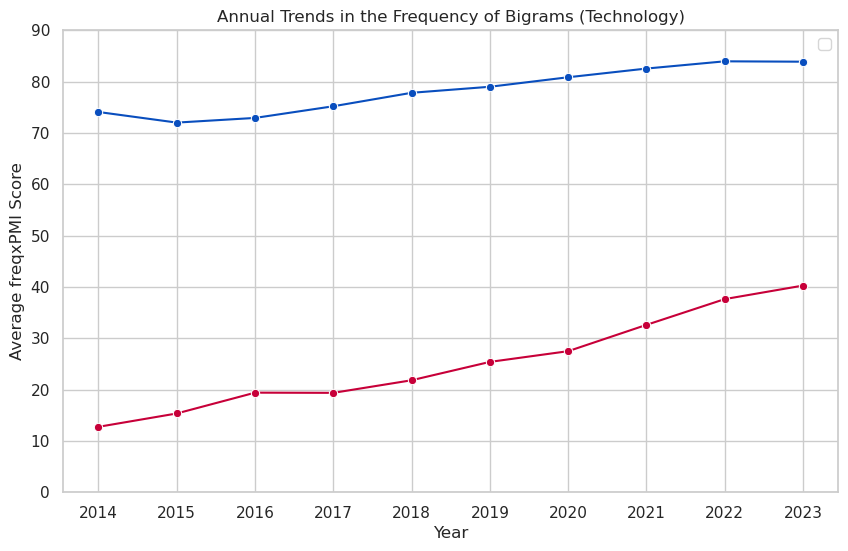

In [43]:
# 绘制折线图显示趋势
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

for category in research_categories.keys():
    cat_df = annual_trends[annual_trends['Category'] == category]
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Year', y='avg_male_freqxPMI', data=cat_df, color="#094ebe",  marker='o')
    sns.lineplot(x='Year', y='avg_female_freqxPMI', data=cat_df, color="#c70039",  marker='o')
    
    plt.title(f"Annual Trends in the Frequency of Bigrams ({category})")
    plt.xlabel('Year')
    plt.ylabel('Average freqxPMI Score')
    plt.ylim(0, 90)  # 设置纵坐标范围
    plt.xticks(ticks=range(2014, 2024), labels=range(2014, 2024))  # 显示完整年份
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()


In [31]:
# 保存annual_trends为CSV文件
output_path = "/group/geog_pyloo/XY/01_gender/_data/annual_trends.csv"
annual_trends.to_csv(output_path, index=False)

print(f"Data for line plots has been exported to {output_path}")


Data for line plots has been exported to /group/geog_pyloo/XY/01_gender/_data/annual_trends.csv
